In [78]:
from CHECLabPy.stats import binom, poisson, normal_pdf
import numpy as np
from numba import njit, prange
from math import exp, pow, sqrt
import os
from matplotlib import pyplot as plt
%matplotlib notebook

In [79]:
os.environ['NUMBA_NUM_THREADS'] = '6'

In [80]:
@njit(fastmath=True, parallel=True)
def sipm_nb(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_, opct, pap, dap):
    sap = spe_sigma  # Assume the sigma of afterpulses is the same

    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    ped_signal = norm * p_ped * normal_pdf(x, eped, eped_sigma)

    pe_signal = np.zeros(x.size)
    found = False

    # Loop over the possible total number of cells fired
    for k in prange(1, 250):
        pk = 0
        for j in prange(1, k+1):
            pj = poisson(j, lambda_)  # Probability for j initial fired cells

            # Skip insignificant probabilities
            if pj < 1e-4:
                continue

            # Sum the probability from the possible combinations which result
            # in a total of k fired cells to get the total probability of k
            # fired cells
            pk += pj * pow(1-opct, j) * pow(opct, k-j) * binom(k-1, j-1)

        # Skip insignificant probabilities
        if (not found) & (pk < 1e-4):
            continue
        if found & (pk < 1e-4):
            break
        found = True

        # Consider probability of afterpulses
        papk = pow(1 - pap, k)
        p0ap = pk * papk
        pap1 = pk * (1-papk) * papk

        # Combine spread of pedestal and pe (and afterpulse) peaks
        pe_sigma = sqrt(k * spe_sigma ** 2 + eped_sigma ** 2)
        ap_sigma = sqrt(k * sap ** 2 + eped_sigma ** 2)

        # Evaluate probability at each value of x
        pe_signal += norm * (
                p0ap * normal_pdf(x, eped + k * spe, pe_sigma) +
                pap1 * normal_pdf(x, eped + k * spe * (1 - dap), ap_sigma)
        )

    return ped_signal + pe_signal

In [81]:
@njit(fastmath=True)
def sipm_nb_new(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_, opct, pap, dap):
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    ped_signal = norm * p_ped * normal_pdf(x, eped, eped_sigma)

    pe_signal = np.zeros(x.size)
    pk_max = 0

    # Loop over the possible total number of cells fired
    for k in prange(1, 100):
        pk = 0
        for j in prange(1, k+1):
            pj = poisson(j, lambda_)  # Probability for j initial fired cells

            # Skip insignificant probabilities
            if pj < 1e-4:
                continue

            # Sum the probability from the possible combinations which result
            # in a total of k fired cells to get the total probability of k
            # fired cells
            pk += pj * pow(1-opct, j) * pow(opct, k-j) * binom(k-1, j-1)

        # Skip insignificant probabilities
        if pk > pk_max:
            pk_max = pk
        elif pk < 1e-4:
            break

        # Combine spread of pedestal and pe peaks
        pe_sigma = sqrt(k * spe_sigma ** 2 + eped_sigma ** 2)

        # Evaluate probability at each value of x
        pe_signal += norm * pk * normal_pdf(x, eped + k * spe, pe_sigma)

    return ped_signal + pe_signal

In [82]:
kwargs = dict(
    norm=2,
    eped=0,
    eped_sigma=0.1,
    spe=1,
    spe_sigma=0.1,
    lambda_=2,
    opct=0.5,
    pap=0,
    dap=0,
)
x = np.linspace(-1, 300, 300000, dtype=np.double)

<IPython.core.display.Javascript object>


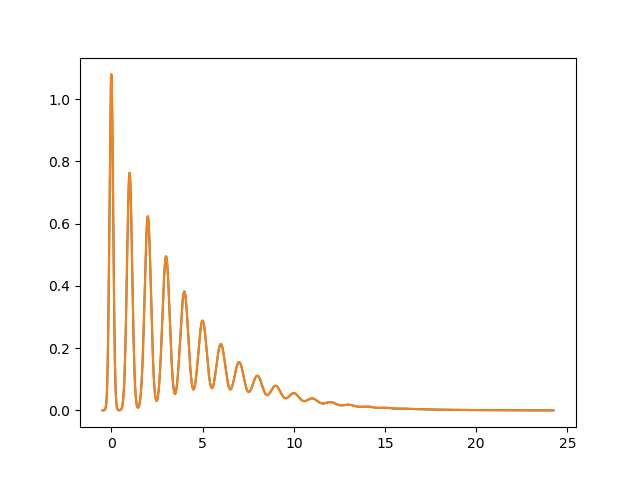

1.99680377339011
1.99680377339011


In [83]:
y_old = sipm_nb(x, **kwargs)
y_new = sipm_nb_new(x, **kwargs)
plt.plot(x[y_old>1e-5], y_old[y_old>1e-5])
plt.plot(x[y_new>1e-5], y_new[y_new>1e-5])
print(np.average(x, weights=y_old) / kwargs['lambda_'])
print(np.average(x, weights=y_new) / kwargs['lambda_'])

In [84]:
%timeit sipm_nb(x, **kwargs)
%timeit sipm_nb_new(x, **kwargs)

28.2 ms ± 566 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.1 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
